In [18]:
import numpy as np
import matplotlib.pyplot as plt
from pynq import allocate

In [19]:
from pynq import PL
PL.reset()
import xrfdc

In [20]:
from pynq import Overlay
ol = Overlay('./design_1.bit')

In [21]:
# sanity check that we are at 150 MHz
from pynq import Clocks
Clocks.pl_clk0_mhz = 150
print(Clocks.pl_clk0_mhz)

150


In [22]:
rf = ol.usp_rf_data_converter_0
adc_tile = rf.adc_tiles[2]
adc_block = adc_tile.blocks[0]
adc_block.Dither = 0 #doesn't really matter for this lab, but let's turn off.
center_frequency = 1575.43
doppler = 0
adc_block.MixerSettings['Freq']= center_frequency + doppler / 1000 # set the frequency of the Numerically controlled oscillator.
adc_block.UpdateEvent(xrfdc.EVENT_MIXER) #every time setting is changed, must call this.
print(adc_block.MixerSettings)

{'Freq': 1575.429999999993, 'PhaseOffset': 0.0, 'EventSource': 2, 'CoarseMixFreq': 0, 'MixerMode': 3, 'FineMixerScale': 0, 'MixerType': 2}


In [23]:
N = 4096
num_width = 32

In [24]:
mmio_interface = ol.mmio_interface
dma_output = ol.axi_dma_0
dma_prn_config = ol.axi_prn_config
dma_iq_config = ol.axi_iq_config
dma_ifft_config = ol.axi_ifft_config

In [25]:
# set up ffts
fft_config = allocate(1, dtype=np.uint8)
fft_config[0] = 0
ifft_config = allocate(1, dtype=np.uint8)
ifft_config[0] = 1
# note they are default inverse (1)
dma_prn_config.sendchannel.transfer(fft_config)
dma_prn_config.sendchannel.wait()
dma_iq_config.sendchannel.transfer(fft_config)
dma_iq_config.sendchannel.wait()
dma_ifft_config.sendchannel.transfer(ifft_config)
dma_ifft_config.sendchannel.wait()

In [26]:
# numerical helpers
def get_twos_from_decimal(decimal, num_bits):
    decimal = int(decimal)
    return decimal % (1<<num_bits)

def get_value_from_complex(real, imag, num_bits):
    return get_twos_from_decimal(real, num_bits)*(1<<num_bits)+get_twos_from_decimal(imag, num_bits)

def get_decimal_from_twos(twos, num_bits):
    twos = int(twos)
    if twos >= (1<<(num_bits-1)):
        return twos - (1<<num_bits)
    else:
        return twos
    
def get_components(complex_array, num_bits):
    return {
        'real': np.array([get_decimal_from_twos(x // (1<<num_bits), num_bits) for x in complex_array]),
        'imag': np.array([get_decimal_from_twos(x % (1<<num_bits), num_bits) for x in complex_array])
    }

In [27]:
### THIS IS FOR DEBUGGING. GO FURTHER DOWN FOR REAL CODE

In [28]:
dma_iq = ol.axi_iq_debug
dma_prn = ol.axi_prn_debug

AttributeError: Could not find IP or hierarchy axi_iq_debug in overlay

In [ ]:
### for debugging
# we currently expect the IQ data to come out on a trigger
mmio_interface.write(0x04, 1)
mmio_interface.write(0x08, 0)
mmio_interface.write(0x08, 1)
iq_data = allocate(N, dtype=np.uint32)
dma_iq.recvchannel.transfer(iq_data)
dma_iq.recvchannel.wait()
prn_data = allocate(N, dtype=np.uint32)
dma_prn.recvchannel.transfer(prn_data)
dma_prn.recvchannel.wait()

In [ ]:
iq_complex = get_components(iq_data, 16)
prn_complex = get_components(prn_data, 16)
iq_numpy = np.array([x+y*1j for (x, y) in zip(iq_complex['real'], iq_complex['imag'])])
prn_numpy = np.array([x+y*1j for (x, y) in zip(prn_complex['real'], prn_complex['imag'])])

In [ ]:
# Open a binary file for writing
with open('out-1209-4096-sample.dat', 'wb') as f:
    for num in arr:
        real = np.int16(num.real)   # Convert real part to 16-bit signed integer
        imag = np.int16(num.imag)   # Convert imaginary part to 16-bit signed integer
        
        # Pack the real and imaginary parts into 4 bytes (2 bytes each)
        # Format: 'hh' means two signed short integers (2 bytes each)
        packed_data = struct.pack('hh', real, imag)
        
        # Write the packed data to the file
        f.write(packed_data)

In [ ]:
convolve = np.fft.ifft(np.fft.fft(iq_numpy) * np.fft.fft(prn_numpy).conj())

In [ ]:
plt.plot(list(range(N)), abs(convolve))

In [ ]:
# now check: was the CA code correct? check PRN 16
with open('ca.mem', 'r') as f:
    data = [1 if line == '7fff\n' else -1 for line in f]
arr = np.array(data)
assert arr.size == N  * 37, f"Expected 4096 * 37 values, but got {arr.size}"
reshaped_arr = arr.reshape(37, N)
print(reshaped_arr.shape)  # Should print (37, 4096)

In [ ]:
prn_from_python = reshaped_arr[1, :]
for i, (a, b) in enumerate(zip(prn_from_python, prn_numpy)):
    if a == 1 and b.real < 32765:
        print(i, a, b)
    elif a == -1 and b.real > -32766:
        print(i, a, b)

In [ ]:
# software test
amplitudes = []
doppler_range = list(range(-15000, 15000, 100))
for doppler in doppler_range:
#     if doppler % 1000 == 0: print(f'on doppler {doppler}')
    t = np.arange(0, N) * 1/4.096e6
    iq_numpy_dopplered = iq_numpy * np.exp(-1j * 2*np.pi * doppler * t)
    convolve = np.fft.ifft(np.fft.fft(iq_numpy_dopplered) * np.fft.fft(prn_numpy).conj())
    peak_position = np.argmax(abs(convolve))
    amplitudes.append(abs(convolve)[peak_position]**2)
plt.plot(doppler_range, amplitudes)
best_doppler = np.argmax(amplitudes)
print(best_doppler, doppler_range[best_doppler], amplitudes[best_doppler])

In [263]:
### HERE IS THE REAL CODE

In [10]:
# start listening, then set trigger (can be in either order?), and wait

mmio_interface.write(0x08, 0)
res_data = allocate(2*N, dtype=np.uint32)
mmio_interface.write(0x08, 1)
dma_output.recvchannel.transfer(res_data)
dma_output.recvchannel.wait()

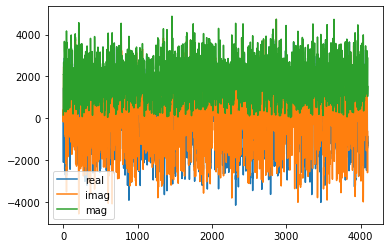

In [11]:
# 64 bit imprecision
real = res_data[1::2]
imag = res_data[0::2]
real_decimal = [get_decimal_from_twos(x, num_width) for x in real]
imag_decimal = [get_decimal_from_twos(x, num_width) for x in imag]

plt.plot(list(range(N)), real_decimal, label='real')
plt.plot(list(range(N)), imag_decimal, label='imag')
plt.plot(list(range(N)), [np.sqrt(r**2+i**2) for (r, i) in zip(real_decimal, imag_decimal)], label='mag')
plt.legend()

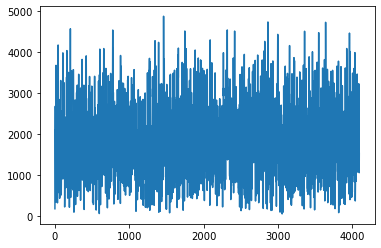

In [12]:
convolve = np.array([x+y*1j for (x,y) in zip(real_decimal, imag_decimal)])
plt.plot(list(range(N)), abs(convolve))

In [13]:
res_data = allocate(2*N, dtype=np.uint32)

on doppler -15000
on doppler -14000
on doppler -13000
on doppler -12000
on doppler -11000
on doppler -10000
on doppler -9000
on doppler -8000
on doppler -7000
on doppler -6000
on doppler -5000
on doppler -4000
on doppler -3000
on doppler -2000
on doppler -1000
on doppler 0
on doppler 1000
on doppler 2000
on doppler 3000
on doppler 4000
on doppler 5000
on doppler 6000
on doppler 7000
on doppler 8000
on doppler 9000
on doppler 10000
on doppler 11000
on doppler 12000
on doppler 13000
on doppler 14000
91 -5900 44284885.0


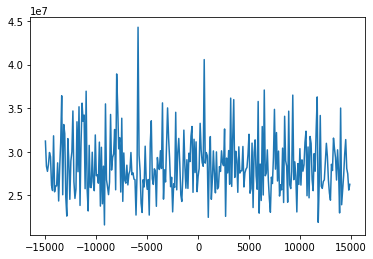

In [17]:
# set up interface
# scaling is reg 0[3:0]
mmio_interface.write(0x00, 16)
# prn is reg 1[5:0]
mmio_interface.write(0x04, 0)
# trigger is reg 2[0]
amplitudes = []
doppler_range = list(range(-15000, 15000, 100))
for doppler in doppler_range:
    # set trigger low first
    mmio_interface.write(0x08, 0)
    
    if doppler % 1000 == 0: print(f'on doppler {doppler}')
    # set adc frequency now
    adc_block.MixerSettings['Freq']= center_frequency + doppler / 1000 # set the frequency of the Numerically controlled oscillator.
    adc_block.UpdateEvent(xrfdc.EVENT_MIXER) #every time setting is changed, must call this.
    # set trigger low, then high to read

    mmio_interface.write(0x08, 1)
    dma_output.recvchannel.transfer(res_data)
    dma_output.recvchannel.wait()
    # now do calculation
    real = res_data[1::2]
    imag = res_data[0::2]
    real_decimal = [get_decimal_from_twos(x, num_width) for x in real]
    imag_decimal = [get_decimal_from_twos(x, num_width) for x in imag]
    convolve = np.array([x+y*1j for (x,y) in zip(real_decimal, imag_decimal)])
    peak_position = np.argmax(abs(convolve))
    amplitudes.append(abs(convolve)[peak_position]**2)
plt.plot(doppler_range, amplitudes)
best_doppler = np.argmax(amplitudes)
print(best_doppler, doppler_range[best_doppler], amplitudes[best_doppler])